In [1]:
import pandas as pd
import modules.preprocessing.sampling as sampling
import modules.preprocessing.scaling as scaling
import modules.constants as const

import numpy as np
import modules.training.LSTMmodels as LSTMmodels
import torch.nn as nn
import torch.optim as optim
import modules.training.training as train

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



### Load data

In [2]:
df_X = pd.read_csv(const.input_X_dir + "Market.csv")
df_y = pd.read_csv(const.input_y_dir + "Target.csv")
dates_df = pd.read_csv(const.input_y_dir + "Dates.csv")

dates = dates_df.values.flatten()

X = df_X.values
y = df_y.values

### Prepare data for training

In [4]:
test_size = sampling.calculate_test_size_from_date(const.test_start_date)
window_size = 10
step_size = 1
batch_size = 10

do_segmentation = False

train_dates, test_dates = sampling.get_train_test_split(dates, test_size=test_size)
train_dates = pd.to_datetime(train_dates)
test_dates = pd.to_datetime(test_dates)

In [5]:
 # Split the data into train and test
X_train_og, X_test_og = sampling.get_train_test_split(X, test_size)
y_train_og, y_test_og = sampling.get_train_test_split(y, test_size)

# Perform scaling on input variables, target variable does not need to be scaled
scaler = None
do_segmentation = True
if do_segmentation:
    segment_ind = scaling.get_segment_indexes(test_size)
    scaler = StandardScaler()
    X_train_sc, X_test_sc = scaling.scale_per_segment(X_train_og, X_test_og, segment_ind, scaler)
    y_train_sc, y_test_sc = scaling.scale_per_segment(y_train_og, y_test_og, segment_ind, scaler)
else:
    scaler = StandardScaler()
    X_train_sc, X_test_sc = scaling.scale_train_and_test(X_train_og, X_test_og, scaler)
    y_train_sc, y_test_sc = scaling.scale_train_and_test(y_train_og, y_test_og, scaler)

# Convert data into form appropriate for LSTM using sliding window technique
X_train, y_train = sampling.apply_sliding_window(X_train_sc, y_train_sc, window_size, step_size)
X_test, y_test = sampling.apply_sliding_window(X_test_sc, y_test_sc, window_size, step_size)



In [6]:
train_loader = sampling.make_data_loader(X_train, y_train, batch_size=batch_size)

### Set model hyperparameters

### Train the model

In [10]:
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import torch

In [127]:
def build_LSTM(input_shape, dropout=0.2, layers=3, units=64):
  model = Sequential()
  model.add(LSTM(units = units, return_sequences = True, input_shape = input_shape))
  for i in range(layers):
      model.add(LSTM(units = units, return_sequences = True))
      model.add(Dropout(dropout))
  model.add(LSTM(units = units))
  model.add(Dropout(dropout))
  model.add(Dense(units = 1))
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  return model

In [128]:
model = build_LSTM(input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.2, layers=2, units=128)
hist = model.fit(X_train, y_train, epochs = 20)

Epoch 1/20
40/40 [==============================] - 6s 27ms/step - loss: 0.7395
Epoch 2/20
40/40 [==============================] - 1s 25ms/step - loss: 0.5992
Epoch 3/20
40/40 [==============================] - 1s 25ms/step - loss: 0.5078
Epoch 4/20
40/40 [==============================] - 1s 25ms/step - loss: 0.4699
Epoch 5/20
40/40 [==============================] - 1s 24ms/step - loss: 0.4220
Epoch 6/20
40/40 [==============================] - 1s 24ms/step - loss: 0.3797
Epoch 7/20
40/40 [==============================] - 1s 25ms/step - loss: 0.3540
Epoch 8/20
40/40 [==============================] - 1s 25ms/step - loss: 0.3205
Epoch 9/20
40/40 [==============================] - 1s 24ms/step - loss: 0.3156
Epoch 10/20
40/40 [==============================] - 1s 24ms/step - loss: 0.2926
Epoch 11/20
40/40 [==============================] - 1s 25ms/step - loss: 0.2696
Epoch 12/20
40/40 [==============================] - 1s 24ms/step - loss: 0.2618
Epoch 13/20
40/40 [==================

In [129]:
predict = model.predict(X_test)
predict_unscaled = scaler.inverse_transform(predict)

16/16 [==============================] - 1s 9ms/step


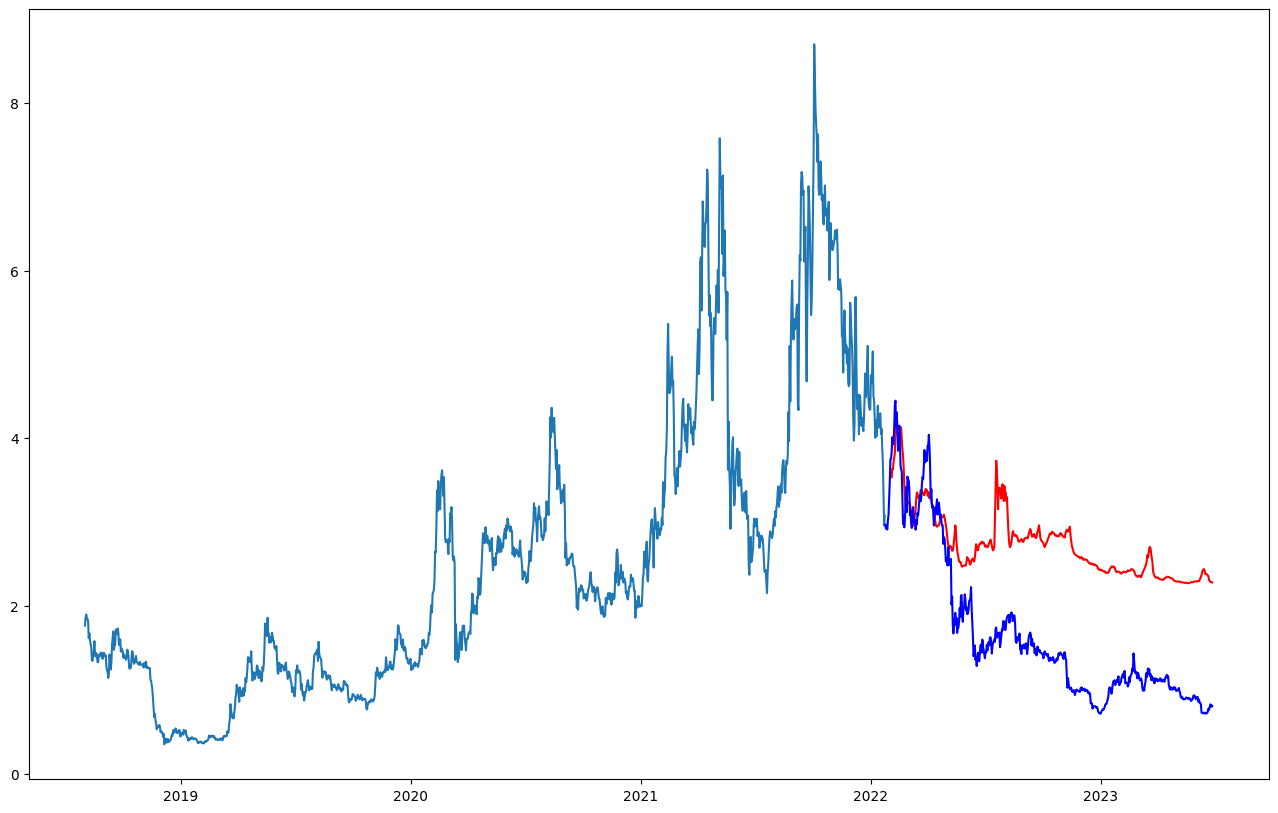

In [130]:
time  = np.arange(len(predict))

plt.figure(figsize=(16,10))

plt.plot(train_dates, y_train_og)

plt.plot(test_dates[window_size:], predict_unscaled, color='red')
plt.plot(test_dates, y_test_og, color='blue')

plt.show()

In [18]:
n_features = X.shape[1]
n_hidden = 64
output_dim = 1
learning_rate = 0.001

model = LSTMmodels.LSTMSimple(input_size=n_features, hidden_size=n_hidden, output_size=output_dim)

# Define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
train_loss = []
n_epochs = 100

for epoch in range(n_epochs):
    for batch_data, batch_targets in train_loader:

        batch_data = batch_data.to(torch.float32)
        batch_targets = batch_targets.to(torch.float32)

        optimizer.zero_grad()

        outputs = model(batch_data)
        # print(outputs.detach().numpy().flatten())
        # print(batch_targets.detach().numpy().flatten())
        # print("-----------------------------------------")
        loss = loss_fn(outputs, batch_targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    train_loss.append(loss.item())
    if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0015
Epoch [20/100], Loss: 0.0000
Epoch [30/100], Loss: 0.0000
Epoch [40/100], Loss: 0.0023
Epoch [50/100], Loss: 0.0151
Epoch [60/100], Loss: 0.0005
Epoch [70/100], Loss: 0.0060
Epoch [80/100], Loss: 0.0517
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0103


In [27]:
predictions = []
test_losses = []


for i, sample in enumerate(X_test):
    with torch.no_grad():
        sample_reshaped = sample.reshape(1, 10, 16)


        test_input = torch.Tensor(sample_reshaped)
        test_target = torch.Tensor(y_test[i] ) 

        model_prediction = model(test_input)
        #print(model_prediction, test_target)
        predictions.append(model_prediction)

        # Calculate the test loss
        test_loss = loss_fn(model_prediction, test_target)
        test_loss_scalar = test_loss.item()

        test_losses.append(test_loss_scalar)


In [1]:
predictions = np.array(predictions)
predictions_unscaled = scaler.inverse_transform(predictions.reshape(-1,1))

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_og, 'r-')
plt.plot(test_dates[window_size:], predictions_unscaled, 'b-')

NameError: name 'np' is not defined

testing

In [4]:
df_X = pd.read_csv(const.input_X_dir + "Market.csv")
df_y = pd.read_csv(const.input_y_dir + "Target.csv")
dates_df = pd.read_csv(const.input_y_dir + "Dates.csv")

dates = dates_df.values.flatten()

X = df_X.values
y = df_y.values

In [10]:
import modules.training.training as training

In [3]:
TEST_SIZE = sampling.calculate_test_size_from_date(const.test_start_date)
WINDOW_SIZE = 30
STEP_SIZE = 1
OUTPUT_DIM = 1

mse_loss = nn.MSELoss()

N_EPOCHS = 100
N_HIDDEN = 128
LR = 0.001

BATCH_SIZE = 128

In [5]:
X_train, y_train, X_test, y_test, scaler = sampling.prepare_input_data(X, y, test_size=TEST_SIZE, window_size=WINDOW_SIZE, step_size=STEP_SIZE, do_segmentation=False)
train_loader = sampling.make_data_loader(X_train, y_train, batch_size=BATCH_SIZE)

In [21]:
model = LSTMmodels.LSTMSimple(input_size=X_train.shape[2], hidden_size=N_HIDDEN, output_size=OUTPUT_DIM)
optimizer = optim.Adam(model.parameters(), lr=LR)

# Train the model
model, _ = training.train_model(model, train_loader, n_epochs=100, optimizer=optimizer, loss_fn = mse_loss)



In [22]:
# Predict on the full test set and measure performance
predictions1, _ = training.make_prediction(model, X_test, y_test, mse_loss)

predictions1_unsc = scaler.inverse_transform(predictions1.reshape(-1,1))
y_test_unsc = scaler.inverse_transform(y_test.reshape(-1,1))
metrics1 = training.get_all_relevant_metrics(prediction=predictions1_unsc, targets=y_test)

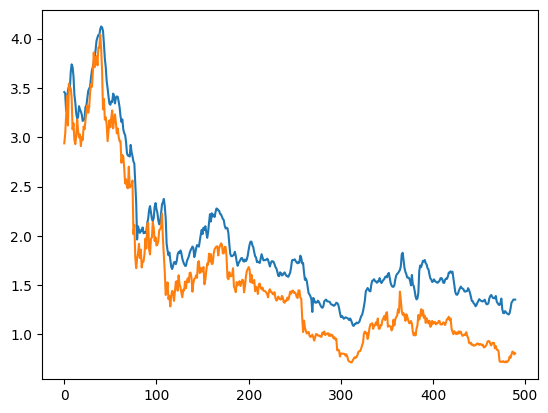

In [23]:
plt.plot(range(len(predictions1_unsc)), predictions1_unsc)
plt.plot(range(len(y_test)), y_test_unsc)